# Chest X-ray Classification and Localization using DenseNet

This notebook implements a transfer learning approach using DenseNet for chest X-ray classification and localization on the NIH Chest X-ray dataset.

In [1]:
!pip install torch torchvision pandas numpy matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 43.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 254.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 223.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 169.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 28.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 68.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Loading and Preprocessing

In [2]:
# Define paths
BASE_PATH = 'DL_for_HIN_Chest_X_Ray'
IMAGES_PATH = os.path.join(BASE_PATH, 'archive','images', 'images')
CSV_PATH = os.path.join(BASE_PATH, 'Data_Entry_2017_filtered_2.csv')
BBOX_PATH = os.path.join(BASE_PATH,'archive', 'BBox_List_2017.csv')

# Load the filtered dataset
df = pd.read_csv(CSV_PATH)
df.rename(columns={'Finding Labels': 'Finding Label'}, inplace=True)
df.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x', 'y]'], inplace=True)
no_finding_images = df[df['Finding Label'] == 'No Finding'].head(2016)


bbox_df = pd.read_csv(BBOX_PATH)
bbox_df.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], inplace=True)
bbox_df.columns = ['Image Index','Finding Label', 'x', 'y', 'width', 'height']

combined_df = pd.concat([no_finding_images, bbox_df])

combined_df.shape
combined_df['Image Index'].value_counts()

combined_df[combined_df['Image Index'] == '00010277_000.png']

FileNotFoundError: [Errno 2] No such file or directory: 'DL_for_HIN_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'

In [144]:
import os
from PIL import Image

# Define the new directory to save resized images
resized_images_dir = 'resized_images'
os.makedirs(resized_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Strip whitespace from image filenames
combined_df['Image Index'] = combined_df['Image Index'].str.strip()

# Iterate over all images_[XXX] folders in the archive directory
archive_path = os.path.join('DL_for_HIN_Chest_X_Ray', 'archive')  # Adjust this path as needed

# Resize and save images
for index, row in combined_df.iterrows():
    image_name = row['Image Index']
    found = False  # Flag to check if the image was found

    # Walk through the archive directory
    for root, dirs, files in os.walk(archive_path):
        if image_name in files:
            image_path = os.path.join(root, image_name)  # Construct the full image path
            print(f"Found image: {image_path}")  # Debugging line
            found = True
            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Resize the image
                    img_resized = img.resize((224, 224))
                    # Save the resized image to the new directory
                    img_resized.save(os.path.join(resized_images_dir, image_name))
                    print(f"Saved resized image: {image_name}")  # Debugging line
            except OSError as e:
                print(f"Error processing {image_name}: {e}")
            except Exception as e:
                print(f"Unexpected error with {image_name}: {e}")
            break  # Exit the loop once the image is found

    if not found:
        print(f"File does not exist in any subdirectory: {image_name}")
    print(index)

Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000002_000.png
Saved resized image: 00000002_000.png
1
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_000.png
Saved resized image: 00000005_000.png
3
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_001.png
Saved resized image: 00000005_001.png
4
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_002.png
Saved resized image: 00000005_002.png
5
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_003.png
Saved resized image: 00000005_003.png
6
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_004.png
Saved resized image: 00000005_004.png
7
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000005_005.png
Saved resized image: 00000005_005.png
8
Found image: DL_for_HIN_Chest_X_Ray/archive/images_001/images/00000006_000.png
Saved resized image: 00000006_000.png
10
Found image: DL_for_HIN_Chest_X_Ray/archive/ima

KeyboardInterrupt: 

In [153]:
combined_df.to_csv('bbox_resized_filtered_images.csv', index=False)

## Training Model

In [4]:
IMAGES_PATH_RESIZED = os.path.join('resized_images')
PREPROCESSED_IMAGES_PATH = os.path.join('bbox_resized_filtered_images.csv')
df_preprocessed = pd.read_csv(PREPROCESSED_IMAGES_PATH, usecols=["Image Index", "Finding Label"])

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ChestXrayDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        # Get labels (binary classification: normal vs abnormal)
        label = 1 if self.df.iloc[idx]['Finding Label'] != 'No Finding' else 0
        return image, torch.tensor(label, dtype=torch.float32)

Using device: cuda


In [6]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return > 0
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU

True
1
NVIDIA A40


In [8]:
def get_transforms():
    """Define image transformations."""
    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

# Split data and create data loaders
train_df, temp_df = train_test_split(df_preprocessed, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Get transforms
transforms_dict = get_transforms()

# Create datasets
train_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, train_df, transform=transforms_dict['train'])
val_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, val_df, transform=transforms_dict['val'])
test_dataset = ChestXrayDataset(IMAGES_PATH_RESIZED, test_df, transform=transforms_dict['val'])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 2400
Validation samples: 300
Test samples: 300


In [9]:
from torchvision import models

def create_model():
    """Create a DenseNet model with transfer learning."""
    # Load pre-trained DenseNet
    model = models.densenet121(pretrained=True)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    
    return model.to(device)

# Create model
model = create_model()
#print(model)

/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/XAI_medical_deeplearning/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    """Train the model."""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_densenet_model.pth')
            print('Model saved!')
        
        print('-' * 60)
    
    return train_losses, val_losses

def plot_training_history(train_losses, val_losses):
    """Plot training history."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/10: 100%|██████████| 75/75 [00:03<00:00, 21.41it/s]


Epoch 1/10:
Training Loss: 0.5834, Training Accuracy: 69.75%
Validation Loss: 0.5183, Validation Accuracy: 74.00%
Model saved!
------------------------------------------------------------


Epoch 2/10: 100%|██████████| 75/75 [00:02<00:00, 26.07it/s]


Epoch 2/10:
Training Loss: 0.5176, Training Accuracy: 74.00%
Validation Loss: 0.4832, Validation Accuracy: 78.00%
Model saved!
------------------------------------------------------------


Epoch 3/10: 100%|██████████| 75/75 [00:02<00:00, 25.51it/s]


Epoch 3/10:
Training Loss: 0.5015, Training Accuracy: 76.04%
Validation Loss: 0.4777, Validation Accuracy: 76.67%
Model saved!
------------------------------------------------------------


Epoch 4/10: 100%|██████████| 75/75 [00:02<00:00, 26.06it/s]


Epoch 4/10:
Training Loss: 0.4805, Training Accuracy: 76.33%
Validation Loss: 0.4741, Validation Accuracy: 76.33%
Model saved!
------------------------------------------------------------


Epoch 5/10: 100%|██████████| 75/75 [00:02<00:00, 25.50it/s]


Epoch 5/10:
Training Loss: 0.5027, Training Accuracy: 75.96%
Validation Loss: 0.4681, Validation Accuracy: 78.33%
Model saved!
------------------------------------------------------------


Epoch 6/10: 100%|██████████| 75/75 [00:02<00:00, 26.10it/s]


Epoch 6/10:
Training Loss: 0.4864, Training Accuracy: 76.67%
Validation Loss: 0.4731, Validation Accuracy: 77.00%
------------------------------------------------------------


Epoch 7/10: 100%|██████████| 75/75 [00:02<00:00, 25.73it/s]


Epoch 7/10:
Training Loss: 0.4601, Training Accuracy: 77.96%
Validation Loss: 0.4709, Validation Accuracy: 77.67%
------------------------------------------------------------


Epoch 8/10: 100%|██████████| 75/75 [00:02<00:00, 25.89it/s]


Epoch 8/10:
Training Loss: 0.4457, Training Accuracy: 78.88%
Validation Loss: 0.4719, Validation Accuracy: 78.00%
------------------------------------------------------------


Epoch 9/10: 100%|██████████| 75/75 [00:02<00:00, 26.03it/s]


Epoch 9/10:
Training Loss: 0.4624, Training Accuracy: 78.54%
Validation Loss: 0.4661, Validation Accuracy: 77.67%
Model saved!
------------------------------------------------------------


Epoch 10/10: 100%|██████████| 75/75 [00:02<00:00, 25.87it/s]


Epoch 10/10:
Training Loss: 0.4477, Training Accuracy: 79.17%
Validation Loss: 0.4743, Validation Accuracy: 77.00%
------------------------------------------------------------


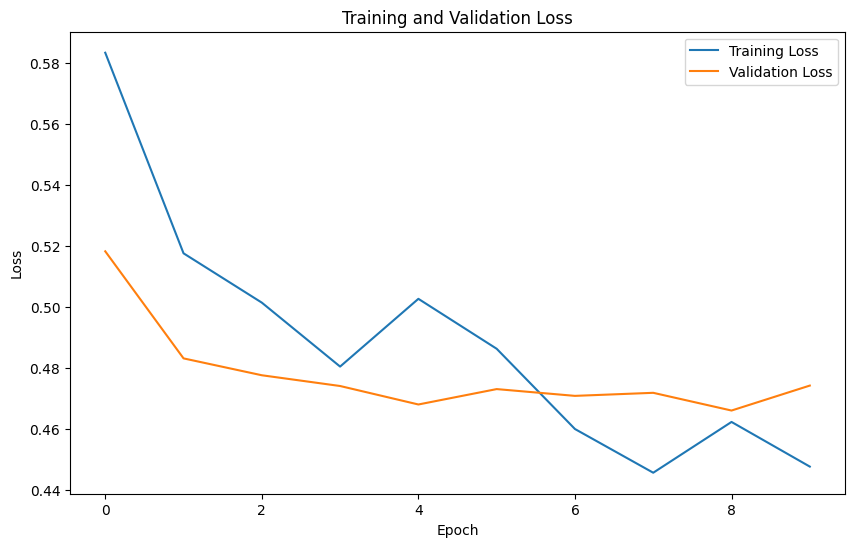

In [11]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=10)

# Plot training history
plot_training_history(train_losses, val_losses)